In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pathlib 
import os
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

import PT_files.save_load as sl
from DnCNN_NP.layers  import relu, np_BatchNorm2d

import time 
from collections import OrderedDict
import pdb

In [2]:
# Loading data & weights dictionary

PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
# name = '6k_model_wb_e800_lys20_58feat.pth'
name = '2k_model_bs64_e800_ps50_Adam.pth'
# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

samp = sample[0][0][1000:3000, 1000:3000]
samp = samp.reshape((1, 1, 2000, 2000))

Shape of test set= (108, 1, 6000, 6000)


In [3]:
def get_indices(input_data, weights_dict, prefix, stride=1, padding=1):
    get_indices_start = time.perf_counter()

    # Get input size
    
    # Checking to see if a single sample or a batch of samples is given.
    # If batch take the batch_size, in_channels, H, and W
    # If single sample is given reshape so the values above can be calculated
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 2000 , 2000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    # Load the weights and biases needed for a convolution
    # then take off gpu memory, move to CPU memory,
    # and lastly transform to numpy
    weight = weights_dict[str(prefix) + 'weight']
    weight = weight.detach().cpu().numpy()
    
    bias = weights_dict[str(prefix) + 'bias']
    bias = bias.detach().cpu().numpy()
    
    # Calculate the kernel size and output channels from
    # the loaded weights from above
    kernel_size = weight[0][0].shape
    output_channels = len(weight)
    
    # Calculations for the output H and W dimensions.
    height_out = ((height + (2*padding) - (kernel_size[0] - 1) - 1) / stride) + 1
    height_out = int(height_out)
    width_out = ((width + (2*padding) - (kernel_size[1] - 1) - 1) / stride) + 1
    width_out = int(width_out)
    
    
    # ----Compute matrix of index i----

    # Level 1 vector.
    level1 = np.repeat(np.arange(kernel_size[0]), kernel_size[1])
    # Duplicate for the other channels.
    level1 = np.tile(level1, input_channels)
    # Create a vector with an increase by 1 at each level.
    everyLevels = stride * np.repeat(np.arange(height_out), width_out)
    # Create matrix of index i at every levels for each channel.
    i = level1.reshape(-1, 1) + everyLevels.reshape(1, -1)
    
    # ----Compute matrix of index j----
    
    # Slide 1 vector.
    slide1 = np.tile(np.arange(kernel_size[1]), kernel_size[0])
    # Duplicate for the other channels.
    slide1 = np.tile(slide1, input_channels)
    # Create a vector with an increase by 1 at each slide.
    everySlides = stride * np.tile(np.arange(width_out), height_out)
    # Create matrix of index j at every slides for each channel.
    j = slide1.reshape(-1, 1) + everySlides.reshape(1, -1)
    
    # ----Compute matrix of index d----

    # This is to mark delimitation for each channel
    # during multi-dimensional arrays indexing.
    d = np.repeat(np.arange(input_channels), kernel_size[0] * kernel_size[1]).reshape(-1, 1)
    
    get_indices_end = time.perf_counter()
    print('get_indices takes:', get_indices_end-get_indices_start, 'seconds')
    
    return i, j, d

def im2col2(input_data, im2col_mat, col_prefix, stride=1, padding=1):
    """
        Transforms our input image into a matrix.

        Parameters:
        -----------
        input_data: nd.array
            The input image(s)
        weights_dict: OrderedDict
            Dictionary containing the PyTorch trained weights for every 
            layer of the model
        prefix: str
            The prefix that picks out the specific layer's weights to be used
            E.g. prefix='layers.0.0.' would be the first layers convolutional
            weights and bias's

        Returns:
        --------
        cols: output matrix.
    """
    im2col_start = time.perf_counter()

    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 2000 , 2000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)

    # Padding
    input_padded = np.pad(input_data, ((0,0), (0,0), (padding, padding), (padding, padding)), mode='constant')
    # Multi-dimensional arrays indexing.
    idx = im2col_mat[str(col_prefix)]
    cols2 = input_padded.reshape(-1)[idx]  
    
    im2col_end = time.perf_counter()
    print('Im2col takes:', im2col_end-im2col_start, 'seconds')
    
    return cols2

def np_Conv2d2(input_data, weights_dict, prefix, im2col_mat, col_prefix):
    """
        Performs a forward convolution.

        Parameters:
        - X : Last conv layer of shape (m, n_C_prev, n_H_prev, n_W_prev).
        Returns:
        - out: previous layer convolved.
    """
    
    conv_start = time.perf_counter()
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 2000 , 2000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)


    output_channels = len(weights_dict[str(prefix) + 'weight']) # num_of_filters
    height_out = int((height + 2 * 1 - 3)/ 1) + 1
    width_out = int((width + 2 * 1 - 3)/ 1) + 1

    
    X_col = im2col2(input_data=input_data, im2col_mat=im2col_mat, col_prefix=str(col_prefix))
    w_col = weights_dict[str(prefix) + 'weight'].detach().cpu().numpy().reshape((output_channels, -1))
    b_col = weights_dict[str(prefix) + 'bias'].detach().cpu().numpy().reshape(-1, 1)
    # Perform matrix multiplication.
    out = w_col @ X_col + b_col
    # Reshape back matrix to image.
    out = np.array(np.hsplit(out, batch_size)).reshape((batch_size, output_channels, height_out, width_out))
    
    conv_end = time.perf_counter()
    print('Conv takes:', conv_end-conv_start, 'seconds')
    return out

In [4]:
im2col_mat = sl.NERSC_load(name='im2col_layer_dict_2k.pkl')

In [5]:
from collections import OrderedDict

# Replace the last part of the key that describes what layer it is
# part of and replaces it with empty space
layers_list = [x.replace('weight', '').replace('bias', '').replace('running_mean', '').replace('running_var', '').replace('num_batches_tracked', '') for x in weights.keys()]
# Convert this list which has duplicated elements due to removing
# identifying elements ie. for the first conv layer we had
# layers.0.0.weight & layers.0.0.bias, but now after removing them we
# have layers.0.0 & layers.0.0
# The code below deletes the duplicated elements
layers_list = list(OrderedDict.fromkeys(layers_list))

In [6]:
# conv2 = np_Conv2d2(input_data=samp,
#                    weights_dict=weights,
#                    prefix='layers.0.0.',
#                    im2col_mat=im2col_mat,
#                    col_prefix='start')

In [7]:
# 1st layer
model_start = time.perf_counter()
output = np_Conv2d2(input_data=samp,
                   weights_dict=weights,
                   prefix=layers_list[0],
                   im2col_mat=im2col_mat,
                   col_prefix='start')

output = relu(output)


for i in range(len(layers_list)-2):
    
    if layers_list[i+1].endswith('0.'):
        
        # conv_start = time.perf_counter()
        output = np_Conv2d2(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[i+1], 
                           im2col_mat=im2col_mat,
                           col_prefix='mid')
        conv_end = time.perf_counter()
        # print('Conv Layer', conv_end-conv_start, 'seconds')
        
    elif layers_list[i+1].endswith('1.'):
        
        # batch_start = time.perf_counter()
        output = np_BatchNorm2d(x=output,
                                weights_dict=weights,
                                prefix=layers_list[i+1])
        output = relu(output)
        batch_end = time.perf_counter()
        # print('Batch Layer', batch_end-batch_start, 'seconds')


output = np_Conv2d2(input_data=output,
                   weights_dict=weights,
                   prefix=layers_list[-1],
                   im2col_mat=im2col_mat,
                   col_prefix='last')

resid_img = samp - output

model_end= time.perf_counter()
print('Total time for 2k by 2k numpy inference takes', model_end-model_start, 'seconds')

Im2col takes: 0.04339951399015263 seconds
Conv takes: 0.413180093979463 seconds
Im2col takes: 2.577195199992275 seconds
Conv takes: 5.155830833973596 seconds
Batch takes 0.5175906920048874 seconds
Im2col takes: 2.5735963440092746 seconds
Conv takes: 5.024744674999965 seconds
Batch takes 0.5262071640172508 seconds
Im2col takes: 2.5790204880177043 seconds
Conv takes: 4.814497109007789 seconds
Batch takes 0.5274914290057495 seconds
Im2col takes: 2.576479012001073 seconds
Conv takes: 4.875559320993489 seconds
Batch takes 0.5196001960139256 seconds
Im2col takes: 2.5717415739782155 seconds
Conv takes: 4.7732882159762084 seconds
Batch takes 0.5292621900152881 seconds
Im2col takes: 2.5730014920118265 seconds
Conv takes: 4.9416344100027345 seconds
Batch takes 0.528723813011311 seconds
Im2col takes: 2.5839007410104387 seconds
Conv takes: 4.976896335021593 seconds
Batch takes 0.526211262011202 seconds
Im2col takes: 2.587477641995065 seconds
Conv takes: 4.909512994985562 seconds
Batch takes 0.5281

In [33]:
def plot_comparison(raw_data,
                    inf_data,
                    size,
                    start_idx,
                    end_idx):
    
    data_6k_raw = raw_data[0][0][0][1000:3000, 1000:3000]
    data_6k_truth = raw_data[1][0][0][1000:3000, 1000:3000]

    full_img_inf = inf_data
    
    assert size == end_idx-start_idx
    
    
    fig, ax = plt.subplots(1, 5,figsize=(30, 26))
    vmin, vmax = np.percentile(data_6k_raw[start_idx:end_idx,start_idx:end_idx], (1,99))


    ax[0].imshow(data_6k_raw[start_idx:end_idx,start_idx:end_idx], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Sample', fontsize=30) 
    ax[1].imshow(np.abs(data_6k_raw[start_idx:end_idx,start_idx:end_idx] - full_img_inf[0][0][start_idx:end_idx,start_idx:end_idx]), vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Noisy-Denoised Residual',fontsize=30) 
    ax[2].imshow(full_img_inf[0][0][start_idx:end_idx,start_idx:end_idx],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Denoised Sample', fontsize=30)
    ax[3].imshow(np.abs(data_6k_truth[start_idx:end_idx,start_idx:end_idx] - full_img_inf[0][0][start_idx:end_idx,start_idx:end_idx]), vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[3].axis('off')
    ax[3].set_title('Truth-Denoised Residual',fontsize=30) 
    ax[4].imshow(data_6k_truth[start_idx:end_idx,start_idx:end_idx], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[4].axis('off')
    ax[4].set_title('Truth Sample', fontsize=30)
    

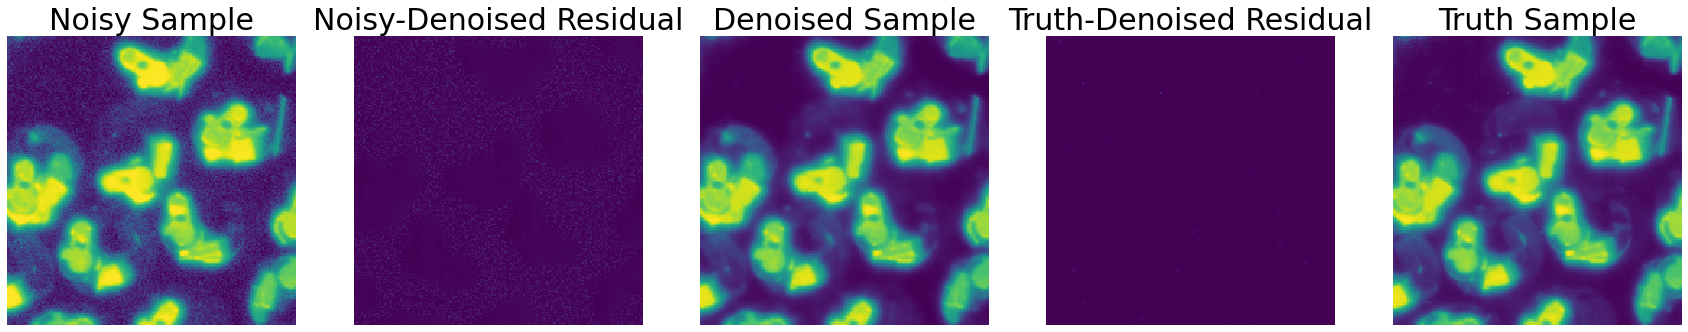

In [34]:
plot_comparison(raw_data=test_data, inf_data=resid_img, size=200, start_idx=1200, end_idx=1400)

# Saving the last necessary `i_last, j_last, d_last` indice matrices and then saving the correct `im2colmat` for the last layer of the model 

Running into problems where the `wcol` and the `X_col` are different shapes and thus unable to be multiplied together. To remedy we are creating the correct last layer indice matrices and updating the saved values we have from before. Then we'll run put these into the updated version of `im2col_mat`

In [10]:
# i_last, j_last, d_last = get_indices(input_data=output, weights_dict=weights, prefix='layers.19.')

# ind = sl.NERSC_load(name='index_matrices_2k.pkl')
# ind['last'] = (i_last, j_last, d_last)
# sl.NERSC_save(name='index_matrices_2k.pkl', data=ind)

## Saving im2col_mat

Now using the newly created index matrices for the last layer and now to create `X_col` in the right shape for the multiplication with `wcol` to take place. We use the `i_last, j_last, d_last` matrices that we saved above in the commented cell to create the multi-dimensional arrays indexing array, which is the output of `im2col2_save` and use this in `np_Conv2d`

In [11]:
def im2col2_save(input_data, layer_matrices,  stride=1, padding=1):
    """
        Transforms our input image into a matrix.

        Parameters:
        -----------
        input_data: nd.array
            The input image(s)
        weights_dict: OrderedDict
            Dictionary containing the PyTorch trained weights for every 
            layer of the model
        prefix: str
            Prefix to use to identify which multi-dimensional array indexing 
            array we're saving (ie. first, mid, last). Similar to the naming
            convetion we have for the individual matrix indices from 
            get_indices

        Returns:
        --------
        cols: output matrix.
    """
    im2col_start = time.perf_counter()

    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 2000 , 2000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)

    # Padding
    input_padded = np.pad(input_data, ((0,0), (0,0), (padding, padding), (padding, padding)), mode='constant')
    i, j, d = layer_matrices
    # Multi-dimensional arrays indexing.
    idx = np.ravel_multi_index(([0], d, i, j), input_padded.shape)
    
    return idx

In [12]:
index_matrices = sl.NERSC_load(name='index_matrices_2k.pkl')

idx_last = im2col2_save(input_data=output, layer_matrices=index_matrices['last'])

In [13]:
# im2col_mat = sl.NERSC_load(name='im2col_layer_dict_2k.pkl')
im2col_mat['last'] = idx_last
sl.NERSC_save(name='im2col_layer_dict_2k.pkl', data=im2col_mat)

You are not on NERSC?
